<a href="https://colab.research.google.com/github/aliash98/BPM_CausalReasoning/blob/main/IDC_MarkovianInput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ylearn

In [ ]:
!pip install networkx==2.8

In [38]:
import networkx as nx
import numpy as np
import pandas as pd
from ylearn.causal_model.graph import CausalGraph
from ylearn.causal_model import CausalModel
import sys
from itertools import chain, combinations

In [52]:
# This function is modified for the IDC algorithm

def markov_to_semimarkov(G):


  G_sm = nx.DiGraph()

  # Rule 1 ------- Adding all observed nodes to the new graph
  for node in G.nodes(data=True):
    if node[1]['color'] == 'blue':
      G_sm.add_node(node[0])
  
  # Rule 2 ------- Importing edges between two blue nodes
  for edge in G.edges(data=True):
    from_node = edge[0]
    to_node = edge[1]
    from_node_color = G.nodes[from_node]['color']
    to_node_color = G.nodes[to_node]['color']
    if from_node_color =='blue' and to_node_color =='blue':
      G_sm.add_edge(edge[0], edge[1])

  # Rule 3 ------- Adding edges for directed paths through grey nodes between two blue nodes
  grey_nodes = [n for n,v in G.nodes(data=True) if v['color'] == 'grey']  
  blue_nodes = [n for n,v in G.nodes(data=True) if v['color'] == 'blue']

  for source in blue_nodes:
    for sink in blue_nodes:
      if source == sink or G.has_edge(source, sink):
        continue
      for path in nx.all_simple_paths(G, source=source, target=sink):
        counter = 0
        for between_node in path:
          if between_node in blue_nodes:
            counter += 1
        if counter == 2:
          G_sm.add_edge(source, sink)
          break
    
  # Rule 4 ------- Extracting the hidden confounders
  confounding_list = []

  for source in grey_nodes:
    potential_confounding = []
    for sink in blue_nodes:
      for path in nx.all_simple_paths(G, source=source, target=sink):
        red_flag = 0
        for between_node in path:
          if between_node in blue_nodes and between_node != sink:
            red_flag = 1
            break
        if red_flag == 0:
          potential_confounding.append(sink)
          break
    if len(potential_confounding) > 1:
      confounding_list.append(potential_confounding)
    
  # we construct a graph for confounding arcs
  G_confounded = nx.Graph()
  number = 1
  hidden_vars = []
  for item in confounding_list:
    name = "U" + str(number)
    G_sm.add_node(name)
    for node in item:
      G_sm.add_edge(name, node)
    hidden_vars.append(name)
    number += 1

  return G_sm, hidden_vars
  # returns graph + list of hidden variables

In [40]:
# function to compute the power set 
def powerset(iterable):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1)))

In [81]:
# IDC - ID implementation by @mattez90

def condset(var,orderlist):
    pos = int(np.where(orderlist==var)[0])
    if pos==0:
        condset = np.array([])
    else:
        # plus one in order to get the node itself
        condset = orderlist[0:pos]
    return condset   


def toposort(varsarray, order):
    return np.array([orderi for orderi in order if orderi in varsarray])


def removeedge(x,G,hiddvar):
    G_del = G.copy()
    for edge in x:
        neighbors = list(G.predecessors(edge)) + list(G.successors(edge))
         #Get the hidden edge
        delete = [u for u in hiddvar.tolist() if u in neighbors] + [edge]
        #Remove node and hidden edge connected to the removed edge
        G_del.remove_nodes_from(delete)
 
    return G_del

def incomingedgedel(nodes,G):
  
    #Retreive the adjency matrix
    adjmtx = nx.to_numpy_matrix(G)
    for nodei in nodes.tolist():
        adjmtx[:,list(nx.nodes(G)).index(nodei)]=0
    #Convert again to a graph object
    G_bar_x = nx.from_numpy_matrix(adjmtx,create_using=nx.DiGraph)
    #Map edge according to the list in the previous graph
    G_ = nx.relabel_nodes(G_bar_x, {i:j for i,j in enumerate(list(nx.nodes(G)))})
      
    return G_

def outcomeedgedel(nodes,G):

    #Retreive the adjency matrix
    adjmtx = nx.to_numpy_matrix(G)
    for nodei in nodes.tolist():
        adjmtx[list(nx.nodes(G)).index(nodei),:]=0
    #Convert again to a graph object
    G_bar_x = nx.from_numpy_matrix(adjmtx,create_using=nx.DiGraph)
    #Map edge according to the list in the previous graph
    G_ = nx.relabel_nodes(G_bar_x, {i:j for i,j in enumerate(list(nx.nodes(G)))})
      
    return G_


def ispresent(x,graph):
    return np.array([node for node in x.tolist() if node  in list(nx.nodes(graph))])


def C_components(graph,hiddvar,orderlist):
 
    adj_mtx  = np.zeros((len(list(nx.nodes(graph))),len(list(nx.nodes(graph)))))
    listnode = list(nx.nodes(graph))
    #Trace all the bi-derected path starting from the empty matrix
    for u in hiddvar:
        if u in listnode:
            neighbors = list(graph.neighbors(u))
            adj_mtx[listnode.index(neighbors[0]),listnode.index(neighbors[1])] = adj_mtx[listnode.index(neighbors[0]),listnode.index(neighbors[1])] + 1
            adj_mtx[listnode.index(neighbors[1]),listnode.index(neighbors[0])] = adj_mtx[listnode.index(neighbors[1]),listnode.index(neighbors[0])] + 1
 
    # Delete nn-observable node from list of nodes and row and column from the
    # adjacency matrix
    adj_mtx2 = np.delete(np.delete(adj_mtx,[listnode.index(u) for u in hiddvar if u in listnode],axis=1),[listnode.index(u) for u in hiddvar if u in listnode],axis=0)
 
    # Delete non observable component
    for u in hiddvar:
         if u in listnode:
            listnode.remove(u)
    Gsub = nx.relabel_nodes(nx.from_numpy_matrix(adj_mtx2), {i:j for i, j in enumerate(listnode)})
    
    # I have to guarantee the topological order inside each C-component and 
    # among different C-component
    
    #Get C-component
    C_comp = [np.array(list(component_i)) for component_i in nx.connected_components(Gsub)]
    
    #Order the c-component
    C_topo = []
    posmax = []
    for ii in range(0,len(C_comp)):
        posmax = [orderlist.tolist().index(Sub_C_i) for Sub_C_i in C_comp[ii]]
        C_topo.append(max(posmax))
    
    C_topo_sort = C_topo.copy()
    C_topo_sort.sort()
    
    newind = [C_topo_sort.index(ii) for ii in C_topo]
    C_comp = [C_comp[idx] for idx in newind]
    #Order element inside C-component
    C_comp = [toposort(C_comp[ii], orderlist) for ii in range(0,len(C_comp))]
    return C_comp

def probabilitystr():
      return{"01_var" : np.array([]), "02_cond" : np.array([]), "03_sumvar" : np.array([]),"05_fraction" : False, "07_sum" : False, "08_prod" : False, "09_branch" : [] ,"04_numerator" : [], "06_denominator" : []}

def an(x,G,orderlist):

    anc = []
    for xx in x.tolist():
        anc.extend(list(nx.ancestors(G,xx)))
        anc.extend(list(x))
    anc = np.array([ordi for ordi in orderlist if ordi in anc])
    return np.array(anc)


def ID(y, x, P, G, orderlist, hiddvar,**kwargs):

    P_out  = P.copy()
    if ("debug" in kwargs):
        debug  = kwargs["debug"]
    else :
        debug = False
    if ("debug" in kwargs):
        debug2  = kwargs["debug2"]
    else :
        debug2 = False

    # Line 0 (preliminary): i) Get observed (current) graph
    #                       ii) Get the list of (currente) node
    if len(ispresent(hiddvar,G)) > 0:
        G_obs = removeedge(ispresent(hiddvar,G),G,ispresent(hiddvar,G))
        v     = np.array(list(nx.nodes(G_obs)))
        v     = np.array([ordi for ordi in orderlist if ordi in v])
    else:
        G_obs = G.copy()
        v     = np.array(list(nx.nodes(G_obs)))
        v     = np.array([ordi for ordi in orderlist if ordi in v])
        
    if debug2:
        print(" ")
        print("--------- Graph information ------------------")
        print("> The edge of the current graph are:")
        print(">>>" + str(list(nx.edges(G))) + ";")
        print(" ")
        print("> The edge of the current observed graph are:")
        print(">>>" + str(list(nx.edges(G_obs))) + ";")
        print("---------------------------------------------")
        print(" ")
    
    #Line 1 of the algorihtm
    if len(x)==0:
        if debug:
            print(">> Enter in Line 1 of the algorithm")
        #Correct cases in Line 6 and 7
        if P_out["08_prod"]==True or P_out["05_fraction"]==True:
            P_out["03_sumvar"] = toposort(np.union1d(np.setdiff1d(v,y),P_out["03_sumvar"]), orderlist)  #list((set(v)-set(y)) | set(P_out["03_sumvar"]))
            P_out["07_sum"]    = True
        else:
            if len(v)==1: #==0 Means just P(var)
                 P_out["07_sum"]    = True
                 P_out["03_sumvar"] = toposort(np.union1d(np.setdiff1d(v,y),P_out["03_sumvar"]), orderlist)   #list((set(v)-set(y)) | set(P_out["03_sumvar"]))
                 
            P_out["01_var"]    = y

        return P_out


    anc = an(y,G_obs,orderlist)
    if len(np.setdiff1d(v,anc)) != 0: #len(set(v) - set(anc)) != 0:
        if debug:
            print(">> Enter in Line 2 of the algorithm")
        #Remove non ancestors(Y) node form the graph
        #G_an    = G.copy()
        edgedel = np.array([u for u in list(nx.nodes(G_obs)) if u not in anc])
        G_an = removeedge(edgedel,G,ispresent(hiddvar,G))
        
        #G_an.remove_nodes_from(edgedel)
        
        if P_out["08_prod"]==True or P_out["05_fraction"]==True:
            P_out["03_sumvar"] = toposort(np.union1d(np.setdiff1d(v,anc),P_out["03_sumvar"]), orderlist)  #list((set(v)-set(anc)) | set(P_out["03_sumvar"]))
            P_out["07_sum"]    = True
        else:
            P_out["01_var"]    = anc    
        P_iter = ID(y,np.intersect1d(x,anc),P_out,G_an,orderlist,hiddvar,**kwargs)
        return P_iter
    G_bar_x  = incomingedgedel(x,G_obs)
    an_bar_x = an(y,G_bar_x,orderlist)
    W        = np.setdiff1d(np.setdiff1d(v,x),an_bar_x) # list((set(v)-set(x)) - set(an_bar_x))
    if len(W) > 0:
        if debug:
            print(">> Enter in Line 3 of the algorithm")
        #x      = x + W
        P_iter = ID(y,np.union1d(x,W),P_out,G,orderlist,hiddvar,**kwargs)
        return P_iter
    G_less_x   = removeedge(x,G,hiddvar)
    C_G_less_x = C_components(G_less_x,hiddvar,orderlist)

    #-> Line 4
    if len(C_G_less_x) > 1:
        if debug:
            print(">> Enter in Line 4 of the algorithm")
            print(">>> Condition ' if C(G\X)={S1, ..., Sk} is valid';")

        P_iter = []
        for p_iter in range(0,len(C_G_less_x)):
            P_iter_i = ID(C_G_less_x[p_iter],np.setdiff1d(v,C_G_less_x[p_iter]),P_out,G,orderlist,hiddvar,**kwargs)
            P_iter.append(P_iter_i)  
                        
        if len(np.setdiff1d(v,np.union1d(y,x))) != 0:
            P_out["07_sum"]    = True
        P_out["08_prod"]   = True
                
        P_out["03_sumvar"] = toposort(np.setdiff1d(v,np.union1d(y,x)), orderlist)
        P_out["09_branch"] = P_iter
        
        return P_out

    if len(C_G_less_x) == 1:
        if debug:
            print(">> Enter in Line 4 of the algorithm")
            print(">>> Condition ' if C(G\X)={S} is valid';")
            
        C_G = C_components(G,hiddvar,orderlist)
        # Line 5 
        if len(C_G)==1: 
            if len(np.setdiff1d(v,C_G))==0:  
                raise ValueError('Graph form an Hedge: causal effect is not identifiable')

        if any([C_G_less_x[0].tolist() == C_Gi.tolist() for C_Gi in C_G]):
            if debug:
                print(">> Enter in Line 6 of the algorithm")
            P_prod_b = []
            
            for ii in range(0,len(C_G_less_x[0])):
                if P_out["08_prod"]==True:
                    #Compute condition set 
                    cond_list = condset(C_G_less_x[0][ii],v)
                    P_prod_i  = complex_prob(P_out,C_G_less_x[0][ii],cond_list,v,orderlist)                 
                else:
                    P_prod_i         = P_out.copy()
                    P_prod_i["01_var"]  = np.array(C_G_less_x[0][ii])
                    cond_list        = condset(C_G_less_x[0][ii],v)
                    P_prod_i["02_cond"] = cond_list
                P_prod_b.append(P_prod_i)                    
                    
            #If the C-component have more than one variable
            if len(C_G_less_x[0]) > 1:
                P_6 = probabilitystr()
                P_6["03_sumvar"]  = toposort(np.setdiff1d(v,np.union1d(y,x)), orderlist)
                P_6["09_branch"]  = P_prod_b.copy()   
                P_6["08_prod"]    = True
            else:
                P_6 = P_prod_b[0].copy()
                if P_6["08_prod"] or P_6["05_fraction"]:
                    P_6["03_sumvar"]  = np.union1d(P_6["03_sumvar"],np.setdiff1d(C_G_less_x[0],y))
                else:
                    P_6["01_var"] =  np.setdiff1d(P_6["01_var"], np.union1d(P_6["03_sumvar"],np.setdiff1d(C_G_less_x[0],y)))
            
            return P_6        
                    
        #-> Line 7
        #For testing if C_G_less_x is a subset of C_Gi I use the difference 
        #function with array: if length is 0 the is a subset
        if any([len(np.setdiff1d(C_G_less_x,C_Gi))==0 for C_Gi in C_G]): 
            if debug:
                print(">> Enter in Line 7 of the algorithm")

            S            = [C_Gi for C_Gi in C_G if len(np.setdiff1d(C_G_less_x,C_Gi))==0][0]
            P_           = probabilitystr()
            P_prod_b     = []

            for iii in range(0,len(S)):
                
                if P_out["08_prod"]==True:
                    cond_list = condset(S[iii],v)
                    P_prod_i  = complex_prob(P_out,S[iii],cond_list,v,orderlist)
                    
                else:
                    P_prod_i         = P_out.copy()
                    P_prod_i["01_var"]  = np.array(S[iii])
                    cond_list        = condset(S[iii],v)
                    P_prod_i["02_cond"] = cond_list
                    
                P_prod_b.append(P_prod_i) 
                     
            if len(S) > 1:
                P_["08_prod"]   = True                        
                P_["09_branch"]  = P_prod_b.copy()
            else:
                P_ = P_prod_b[0].copy()
                
            edgedel = [u for u in list(nx.nodes(G_obs)) if u not in S]
            G_s     = removeedge(edgedel,G,hiddvar)
            P_iter  = ID(y,np.intersect1d(x,S),P_,G_s,orderlist,hiddvar,**kwargs)
    
            return P_iter  
        
def complex_prob(P, var, condset, v, orderlist):
    
    if len(condset) == 0:
        P_complex = P.copy()    
        if P_complex["07_sum"]==True:
            P_complex["03_sumvar"] = toposort(np.union1d(P_complex["03_sumvar"],np.setdiff1d(v,np.union1d(var,condset))), orderlist)
        else:
            P_complex["07_sum"] = True
            P_complex["03_sumvar"] = toposort(np.setdiff1d(v,np.union1d(var,condset)), orderlist)
            
   #If we have the condition set express the conditional probability in terms of 
   # conjunction probability require a denominator
   
    else:
        P_complex = probabilitystr()    
        P_complex["05_fraction"]    = True
        P_complex["04_numerator"]   = P.copy()
        P_complex["06_denominator"] = P.copy()
        if P["07_sum"]==True:
            P_complex["04_numerator"]["03_sumvar"]   = toposort(np.union1d(P["03_sumvar"],np.setdiff1d(v,np.union1d(var,condset))), orderlist)
            P_complex["06_denominator"]["03_sumvar"] = toposort(np.union1d(P["03_sumvar"],np.setdiff1d(v,condset)), orderlist)
        else:
            P_complex["04_numerator"]["03_sumvar"]   = toposort(np.setdiff1d(v,np.union1d(var,condset)), orderlist)
            P_complex["06_denominator"]["03_sumvar"] = toposort(np.setdiff1d(v,condset), orderlist)
           
       
    return P_complex
      
    
def probabilitystr():
      return{  "01_var" : np.array([])
             , "02_cond" : np.array([])
             , "03_sumvar" : np.array([])
             , "04_numerator" : []
             , "05_fraction" : False
             , "06_denominator" : []
             , "07_sum" : False
             , "08_prod" : False
             , "09_branch" : [] }
    
    
    
def IDC(y, x, z, P, G, orderlist, hiddvar,**kwargs):
    
    debug  = kwargs["debug"]
    
    #Transform array y, z and z in array
    y_set = set(list(y))
    
    if all(x) != "":
        x_set = set(list(x))
    z_set = set(list(z))
    #Get graph without incoming edge on x and outgoing edge to z
    G_under_x_bar_z = incomingedgedel(x,outcomeedgedel(z,G))
    for zi in z:
        c_set = x_set.copy()
        c_set | (z_set - {zi})
        if nx.d_separated(G_under_x_bar_z,y_set,{zi},c_set):
            if debug:
                print("> Iterate over IDC: Z variable is " +str(zi))
            P_numerator = IDC(y, np.union1d(x,np.array([zi])),np.setdiff1d(z,np.array([zi])), P, G, orderlist, hiddvar,**kwargs)
            return P_numerator      
    if debug:
        print("> Iterate over ID")
    P_numerator = ID(np.union1d(y,z), x, P, G, orderlist, hiddvar,**kwargs)

    return P_numerator        

        
def ce_identification(y,x,z,P,G,orderlist,hiddvar,**kwargs):
 
   debug  = kwargs["debug"]

   if z.tolist():
       
       if debug:
           print("@@ Condition set z is not empty: IDC version is used")
           
       P_numerator = IDC(y, x, z, P, G, orderlist, hiddvar,**kwargs)
       
       P_prime = probabilitystr()
       
       #Construct the denominator
       P_prime_denominator = P_numerator.copy()
       
       if P_prime_denominator["07_sum"]:
           P_prime_denominator["03_sumvar"] = np.union1d(y,P_prime_denominator["03_sumvar"])
       else:
           P_prime_denominator["07_sum"]    = True
           P_prime_denominator["03_sumvar"] = y
           
       #Add the denominator to whole distribution
       P_prime["05_fraction"]    = True
       P_prime["06_denominator"] = P_prime_denominator
       P_prime["04_numerator"]   = P_numerator

   else:
       if debug:
           print("@@Condition set z is empty: ID version is used")
           
       P_prime = ID(y,x,P,G,orderlist,hiddvar,**kwargs)
       
       
   return P_prime
      

In [79]:
# function

# INPUT: Markovian graph (including observed(blue)/unobserved(grey)), Targer, Intervention (node names), Context variables (as a set)
# OUTPUT: True/False (for the identifiability), [] a set of all possible adjustment sets

def IDC_with_markov(G, T, I, C):

  grey_nodes = [n for n,v in G.nodes(data=True) if v['color'] == 'grey']

  # TODO: encapsulate all these pre-condtions in a auxiliary function
  if T in grey_nodes:
    print('The target variable (T) cannot be unobserved.')
    return False
  if I in grey_nodes:
    print('The intervention variable (I) cannot be unobserved.')
    return False
  for c in C:
    if c in grey_nodes:
      print('The contextual variables (C) cannot be unobserved.')
      return False

  final_graph, hidden_confounders = markov_to_semimarkov(G)

  DG_1 = nx.DiGraph()
  DG_1.add_edges_from(list(final_graph.edges()))
    
  hiddvar          = np.array(hidden_confounders)                # declare an array containign the hidden variables
  Gobs1            = removeedge(hiddvar,DG_1,hiddvar)            # gets the observed graph (so without hidden variable)
  order            = np.array(list(nx.topological_sort(Gobs1)))  # retreive the topological ordering of the graph
  kwargs           = dict()                                      # specify others input
  kwargs["debug"]  = False                                        # diplay the enter interrogated at each step
  kwargs["debug2"] = False                                       # if true, edges of graphs at each steps are diplayed
  P                = probabilitystr()                            # initalize probability structure

  try:
    Pi1 = ce_identification(np.array([T]),np.array([I]),np.array(C), P,DG_1,order,hiddvar,**kwargs)
  except:
    print('Based on the current setting the query is not identifiable.')

    power_set = powerset(grey_nodes)
    adj_sets = []

    for grey_set in power_set:
      H = G.copy()

      grey_list = list(grey_set)
      for grey_node in grey_list:
        nx.set_node_attributes(H, {grey_node: "blue"}, name="color")

      final_graph, hidden_confounders = markov_to_semimarkov(H)

      DG_1 = nx.DiGraph()
      DG_1.add_edges_from(list(final_graph.edges()))
      hiddvar          = np.array(hidden_confounders)                       
      Gobs1            = removeedge(hiddvar,DG_1,hiddvar)            
      order            = np.array(list(nx.topological_sort(Gobs1)))                                       
      P                = probabilitystr()                            

      try:
        Pi1 = ce_identification(np.array([T]),np.array([I]),np.array(C), P,DG_1,order,hiddvar,**kwargs)
      except:
        print("The query is still not identifiable with " + str(grey_list) + " being observed.")
      else:
        print("The query becomes identifiable if " + str(grey_list) + " are observed.")
        adj_sets.append((grey_list, Pi1))

    return False, adj_sets

    #TODO: shrink the adj_sets 
  else:
    print("Based on the current setting the query is already identifiable.")
    return True, Pi1

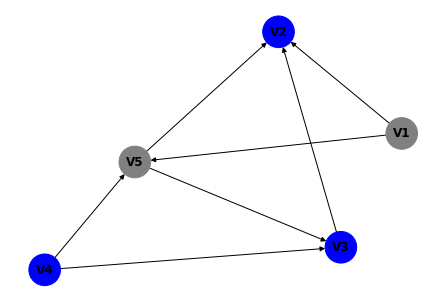

In [70]:
#Example
G = nx.DiGraph()
G.add_nodes_from([
    ('V5', {"color": "grey"}),
    ('V4', {"color": "blue"}),
    ('V3', {"color": "blue"}),
    ('V2', {"color": "blue"}),
    ('V1', {"color": "grey"}),
])
G.add_edge('V5', 'V2')
G.add_edge('V5', 'V3')
G.add_edge('V4', 'V3')
G.add_edge('V3', 'V2')
G.add_edge('V1', 'V5')
G.add_edge('V1', 'V2')
G.add_edge('V4', 'V5')


nx.draw(G, with_labels=True, font_weight='bold', node_size=1000, node_color = [x[1] for x in G.nodes('color')])


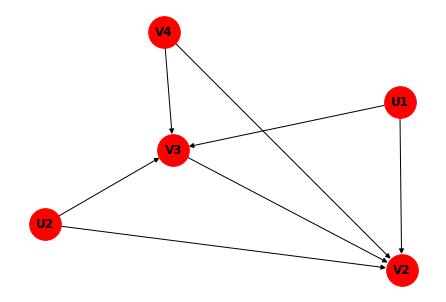

In [71]:
G_folan, l = markov_to_semimarkov(G)
nx.draw(G_folan, with_labels=True, font_weight='bold', node_size=1000, node_color = 'red')

In [82]:
print(IDC_with_markov(G, 'V2', 'V3', ['V4']))

Based on the current setting the query is not identifiable.
The query becomes identifiable if ['V5'] are observed.
The query is still not identifiable with ['V1'] being observed.
The query becomes identifiable if ['V5', 'V1'] are observed.
(False, [(['V5'], {'01_var': array([], dtype=float64), '02_cond': array([], dtype=float64), '03_sumvar': array([], dtype=float64), '04_numerator': {'01_var': array([], dtype=float64), '02_cond': array([], dtype=float64), '03_sumvar': array(['V5'], dtype='<U2'), '04_numerator': [], '05_fraction': False, '06_denominator': [], '07_sum': False, '08_prod': True, '09_branch': [{'01_var': array('V5', dtype='<U2'), '02_cond': array(['V4'], dtype='<U2'), '03_sumvar': array([], dtype=float64), '04_numerator': [], '05_fraction': False, '06_denominator': [], '07_sum': False, '08_prod': False, '09_branch': []}, {'01_var': array('V2', dtype='<U2'), '02_cond': array(['V4', 'V5', 'V3'], dtype='<U2'), '03_sumvar': array([], dtype=float64), '04_numerator': [], '05_fra